# Preparations

<b>Load Libraries</b>

In [1]:
# udf 
import os, sys
cwd = os.getcwd()
os.chdir('../')
path_to_src = os.getcwd()
if path_to_src not in sys.path:
    sys.path.append(path_to_src)
os.chdir(cwd)
##
from src.notebook.support import *
from src.mlflow.support import *

# others 
from warnings import simplefilter

<b>Load Dataset</b>

In [2]:
# materials
materials = prepare_data_to_train(path='../cache/data/cleaned.csv')

<b>MLflow</b>

In [3]:
# local server
mlflow.set_tracking_uri('http://127.0.0.1:5000/')
experiment_name = 'Feature engineering'
try:
    mlflow.create_experiment(name=experiment_name, artifact_location='cache/mlflow/runs/')
except:
    mlflow.set_experiment(experiment_name=experiment_name)

In [4]:
# tags
tags = {'pre_pro': None, 'base_model': None, 
        'feature_selection': 'false', 'beta_f': 2}

# metrics
metrics = {'avg_fbeta': None, 'val_fbeta': None}

# 1. Baseline Evaluation

In [16]:
# dtype's indexs separation
num_iters = materials['X_train'].shape[1]
num_idxes, cat_idxes = [], []
for i in range(num_iters):
    try:
        float(materials['X_train'][0, i])
        num_idxes.append(i)
    except:
        cat_idxes.append(i)

In [21]:
# warnings
simplefilter(action='ignore')

# base models
base_models = load_base_models()

# trasnformers
ct = ColumnTransformer([('num', SimpleImputer(strategy='mean'), num_idxes), 
                        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_idxes)])

# pipeline
pipelines = []
for name, model in base_models:
    pipeline = Pipeline([('trans', ct), 
                         (name, model)])
    pipelines.append((name, pipeline))

kfold_results = get_kfold_results(pipelines, materials['X_train'], materials['y_train'])

LR: 0.5576398777140695 (0.03318352891094596)
KNN: 0.4580758774508246 (0.03971523899930276)
SVM: 0.0 (0.0)
CART: 0.4877050998677607 (0.04100404352911018)
ET: 0.4866171256802644 (0.041132753594308756)
RF: 0.4988824774994805 (0.04005701433661895)
GB: 0.5334757398446867 (0.030294471597094256)
LGBM: 0.534500564541397 (0.03492077482020717)
XGB: 0.5346661648584246 (0.03996922328547825)


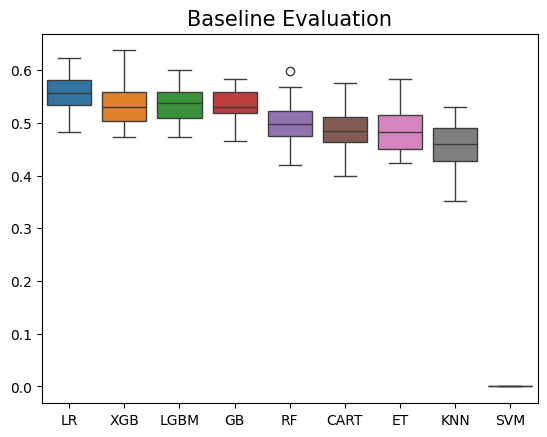

In [22]:
# plot kfold results
plot_kfold_results(kfold_results, 'Baseline Evaluation')

In [33]:
# mlflow
for name, pipeline in pipelines:
    ##
    pipeline.fit(materials['X_train'], materials['y_train'])
    val_predictions = pipeline.predict(materials['X_test'])
    val_fbeta = fbeta_score(y_true=materials['y_test'], y_pred=val_predictions, 
                            beta=2)
    ##
    with mlflow.start_run():
        ### tags
        tags['pre_pro'] = 'si(mean)_ohe'
        tags['base_model'] = name
        mlflow.set_tags(tags)
        ###
        metrics['avg_fbeta'] = kfold_results[name].mean()
        metrics['val_fbeta'] = val_fbeta
        mlflow.log_metrics(metrics)
        ###
        mlflow.sklearn.log_model(artifact_path='model', 
                                 sk_model=pipeline)

In [11]:
# infer pip requirements
runs_id = mlflow.search_runs(
    filter_string="tags.base_model = 'LR' and tags.pre_pro = 'si(mean)_ohe'"
)['run_id'].values[0]
pip_requirements = infer_pip_requirements(
    model_uri=f'runs:/{runs_id}/model', 
    flavor='sklearn'
)
pip_requirements.extend(['mlxtend==0.23.1'])
pip_requirements

['cloudpickle==3.0.0',
 'imbalanced-learn==0.12.3',
 'numpy==1.26.4',
 'psutil==6.0.0',
 'scikit-learn==1.5.1',
 'scipy==1.14.0',
 'mlxtend==0.23.1']

# 2. Scaling

<b>Standardization</b>

In [8]:
# nodes
def scale_test(data: dict) -> tuple[list, list]:
    arr, idxes = data['X'], np.array(data['idxes'])
    mask = pd.isnull(arr[:, idxes]).sum(axis=0) == 0
    passed, failed = idxes[mask].tolist(), idxes[~mask].tolist()

    return passed, failed

def impute_test(data: dict) -> tuple[list, list]:
    return data['idxes'], []

def ohe_test(data: dict) -> tuple[list, list]:
    return data['idxes'], []

std = Node('std', StandardScaler())
std.test = scale_test

impute = Node('impute', make_pipeline(SimpleImputer(), StandardScaler()))
impute.test = impute_test
std.next = impute

ohe = Node('ohe', OneHotEncoder(drop='first', sparse_output=False))
ohe.test = ohe_test

left = [std, impute]
right = [ohe]

tree = InitBinaryTree(left, right)

In [9]:
# warnings
simplefilter(action='ignore')

# artifacts path
artifacts_path = {'feature_selector': '../cache/temp/feature_selector.pkl', 
                  'model': '../cache/temp/model.pkl'}

# base model CHANGE HERE
base_model = get_seleted_models(['XGB'])

# transformers
transformers = SFS(tree)

# pipeline
pipeline = Pipeline([('trans', transformers)] + base_model)

# sfs
sfs = SequentialFeatureSelector(
    estimator=pipeline, k_features='best', forward=True, 
    cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3), 
    scoring=make_scorer(fbeta_score, beta=2),
    verbose=2
)
sfs.fit(materials['X_train'], materials['y_train'])
## dump sfs
dump_model(sfs, artifacts_path['feature_selector'])
## dump pipeline
pipeline.fit(sfs.transform(materials['X_train']), materials['y_train'])
dump_model(pipeline, artifacts_path['model'])


[2024-08-15 21:57:21] Features: 1/19 -- score: 0.2848382638446262
[2024-08-15 21:57:58] Features: 2/19 -- score: 0.48534616424939436
[2024-08-15 21:57:57] Features: 3/19 -- score: 0.5208949186422216
[2024-08-15 21:58:34] Features: 4/19 -- score: 0.5408315286301734
[2024-08-15 21:58:34] Features: 5/19 -- score: 0.5529238845811114
[2024-08-15 21:58:53] Features: 6/19 -- score: 0.5567182594460093
[2024-08-15 21:59:11] Features: 7/19 -- score: 0.5538462516080928
[2024-08-15 21:59:48] Features: 8/19 -- score: 0.5555037326138674
[2024-08-15 21:59:49] Features: 9/19 -- score: 0.5460872579271936
[2024-08-15 22:00:23] Features: 10/19 -- score: 0.5413153375785638
[2024-08-15 22:00:20] Features: 11/19 -- score: 0.5427975332382754
[2024-08-15 22:00:33] Features: 12/19 -- score: 0.5362157932914375
[2024-08-15 22:00:46] Features: 13/19 -- score: 0.5418259934328268
[2024-08-15 22:00:57] Features: 14/19 -- score: 0.5363685172188956
[2024-08-15 22:01:07] Features: 15/19 -- score: 0.5351834582741938
[2

In [12]:
# mlflow
##
val_predictions = pipeline.predict(sfs.transform(materials['X_test']))
val_fbeta = fbeta_score(y_true=materials['y_test'], y_pred=val_predictions, 
                        beta=2)
##
with mlflow.start_run():
    ### tags
    tags['pre_pro'] = 'si(mean)_std_ohe'
    tags['base_model'] = 'XGB' # CHANGE HERE
    tags['feature_selection'] = 'true'
    mlflow.set_tags(tags)
    ### metrics
    metrics['avg_fbeta'] = sfs.k_score_
    metrics['val_fbeta'] = val_fbeta
    mlflow.log_metrics(metrics)
    ### pipeline
    mlflow.pyfunc.log_model(artifact_path='model', 
                            python_model=MLflowModel(), 
                            artifacts=artifacts_path,
                            signature=infer_signature(materials['X_train']), 
                            pip_requirements=pip_requirements)

<b>Power Transformation</b>

In [13]:
# nodes
def scale_test(data: dict) -> tuple[list, list]:
    arr, idxes = data['X'], np.array(data['idxes'])
    mask = pd.isnull(arr[:, idxes]).sum(axis=0) == 0
    passed, failed = idxes[mask], idxes[~mask]

    return passed, failed

def impute_test(data: dict) -> tuple[list, list]:
    return data['idxes'], []

def ohe_test(data: dict) -> tuple[list, list]:
    return data['idxes'], []

scale = Node('pwt', PowerTransformer(method='yeo-johnson'))
scale.test = scale_test

impute = Node('impute', make_pipeline(SimpleImputer(), PowerTransformer(method='yeo-johnson')))
impute.test = impute_test
scale.next = impute

ohe = Node('ohe', OneHotEncoder(drop='first', sparse_output=False))
ohe.test = ohe_test

tree = InitBinaryTree([scale, impute], [ohe])

In [14]:
# warnings
simplefilter(action='ignore')

# artifacts path
artifacts_path = {'feature_selector': '../cache/temp/feature_selector.pkl', 
                  'model': f'../cache/temp/model.pkl'}

# base model CHANGE HERE
base_model = get_seleted_models(['XGB'])

# transformers
transformers = SFS(tree)

# pipeline
pipeline = Pipeline([('trans', transformers)] + base_model)

# sfs
sfs = SequentialFeatureSelector(
    estimator=pipeline, k_features='best', forward=True, 
    cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3), 
    scoring=make_scorer(fbeta_score, beta=2), 
    verbose=2
)
sfs.fit(materials['X_train'], materials['y_train'])
## dump 
dump_model(sfs, artifacts_path['feature_selector'])
## pipeline
pipeline.fit(sfs.transform(materials['X_train']), materials['y_train'])
dump_model(pipeline, artifacts_path['model'])


[2024-08-15 22:03:06] Features: 1/19 -- score: 0.28341820062810874
[2024-08-15 22:03:10] Features: 2/19 -- score: 0.48350243490728734
[2024-08-15 22:03:38] Features: 3/19 -- score: 0.522623153735365
[2024-08-15 22:04:04] Features: 4/19 -- score: 0.536559036235749
[2024-08-15 22:04:25] Features: 5/19 -- score: 0.5488711781883358
[2024-08-15 22:05:04] Features: 6/19 -- score: 0.5563028864534236
[2024-08-15 22:05:24] Features: 7/19 -- score: 0.5520737738787799
[2024-08-15 22:05:24] Features: 8/19 -- score: 0.5487893061228608
[2024-08-15 22:05:43] Features: 9/19 -- score: 0.5510112321786355
[2024-08-15 22:06:18] Features: 10/19 -- score: 0.5490013744480178
[2024-08-15 22:06:15] Features: 11/19 -- score: 0.5420896772626672
[2024-08-15 22:06:29] Features: 12/19 -- score: 0.5345376827092368
[2024-08-15 22:06:43] Features: 13/19 -- score: 0.53611232092141
[2024-08-15 22:06:55] Features: 14/19 -- score: 0.5370485886712547
[2024-08-15 22:07:06] Features: 15/19 -- score: 0.533641923436866
[2024-

In [15]:
# mlflow
##
val_predictions = pipeline.predict(sfs.transform(materials['X_test']))
val_fbeta = fbeta_score(materials['y_test'], val_predictions, 
                        beta=2)
##
with mlflow.start_run():
    ### tags
    tags['pre_pro'] = 'si(mean)_pwt_ohe'
    tags['base_model'] = 'XGB' # CHANGE HERE
    tags['feature_selection'] = 'true'
    mlflow.set_tags(tags)
    ### metrics
    metrics['avg_fbeta'] = sfs.k_score_
    metrics['val_fbeta'] = val_fbeta
    mlflow.log_metrics(metrics)
    ### log
    mlflow.pyfunc.log_model(artifact_path='model', 
                            python_model=MLflowModel(),
                            artifacts=artifacts_path, 
                            signature=infer_signature(materials['X_train']), 
                            pip_requirements=pip_requirements)

<b>Quantile Transformation</b>

In [16]:
# nodes
def scale_test(data: dict) -> tuple[list, list]:
    arr, idxes = data['X'], np.array(data['idxes'])
    mask = pd.isnull(arr[:, idxes]).sum(axis=0) == 0
    passed, failed = idxes[mask], idxes[~mask]

    return passed, failed

def impute_test(data: dict) -> tuple[list, list]:
    return data['idxes'], []

def ohe_test(data: dict) -> tuple[list, list]:
    return data['idxes'], []

scale = Node('qtt', QuantileTransformer(output_distribution='normal'))
scale.test = scale_test

impute = Node('impute', make_pipeline(SimpleImputer(), QuantileTransformer(output_distribution='normal')))
impute.test = impute_test
scale.next = impute

ohe = Node('ohe', OneHotEncoder(drop='first', sparse_output=False))
ohe.test = ohe_test

tree = InitBinaryTree([scale, impute], [ohe])

In [17]:
# warnings
simplefilter(action='ignore')

# artifacts_path
artifacts_path = {'feature_selector': '../cache/temp/feature_selector.pkl', 
                  'model': f'../cache/temp/model.pkl'}

# base model CHANGE HERE
base_model = get_seleted_models(['XGB'])

# transformers
transformers = SFS(tree)

# pipeline
pipeline = Pipeline([('trans', transformers)] + base_model)

# sfs
sfs = SequentialFeatureSelector(
    estimator=pipeline, k_features='best', forward=True, 
    cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3), 
    scoring=make_scorer(fbeta_score, beta=2), 
    verbose=2

)
sfs.fit(materials['X_train'], materials['y_train'])
## dump
dump_model(sfs, artifacts_path['feature_selector'])
## pipeline
pipeline.fit(sfs.transform(materials['X_train']), materials['y_train'])
dump_model(pipeline, artifacts_path['model'])


[2024-08-15 22:08:34] Features: 1/19 -- score: 0.2900314000748436
[2024-08-15 22:08:35] Features: 2/19 -- score: 0.48250413839870304
[2024-08-15 22:09:15] Features: 3/19 -- score: 0.5013323153571979
[2024-08-15 22:09:18] Features: 4/19 -- score: 0.5203649872232681
[2024-08-15 22:09:39] Features: 5/19 -- score: 0.5360221037127605
[2024-08-15 22:10:00] Features: 6/19 -- score: 0.5355919377988712
[2024-08-15 22:10:20] Features: 7/19 -- score: 0.5349649145822254
[2024-08-15 22:10:40] Features: 8/19 -- score: 0.5390474875415411
[2024-08-15 22:10:58] Features: 9/19 -- score: 0.5387627850898783
[2024-08-15 22:11:34] Features: 10/19 -- score: 0.5382127509208129
[2024-08-15 22:11:32] Features: 11/19 -- score: 0.5376697002779393
[2024-08-15 22:11:47] Features: 12/19 -- score: 0.5345296774625776
[2024-08-15 22:12:01] Features: 13/19 -- score: 0.5369038722193834
[2024-08-15 22:12:31] Features: 14/19 -- score: 0.5340351851316739
[2024-08-15 22:12:27] Features: 15/19 -- score: 0.5326239969670926
[2

In [18]:
# mflow
## 
val_predictions = pipeline.predict(sfs.transform(materials['X_test']))
val_fbeta = fbeta_score(materials['y_test'], val_predictions, 
                        beta=2)
##
with mlflow.start_run():
    ### tags
    tags['pre_pro'] = 'si(mean)_qtt_ohe'
    tags['base_model'] = 'XGB' # CHANGE HERE
    tags['feature_selection'] = 'true'
    mlflow.set_tags(tags)
    ### metrics
    metrics['avg_fbeta'] = sfs.k_score_
    metrics['val_fbeta'] = val_fbeta
    mlflow.log_metrics(metrics)
    ###
    mlflow.pyfunc.log_model(artifact_path='model', 
                            python_model=MLflowModel(), 
                            artifacts=artifacts_path, 
                            signature=infer_signature(materials['X_train']), 
                            pip_requirements=pip_requirements)

# 3. Factor Analysis

# 4. Resampling

In [19]:
# nodes
def scale_test(data: dict) -> tuple[list, list]:
    arr, idxes = data['X'], np.array(data['idxes'])
    mask = pd.isnull(arr[:, idxes]).sum(axis=0) == 0
    passed, failed = idxes[mask].tolist(), idxes[~mask].tolist()

    return passed, failed

def impute_test(data: dict) -> tuple[list, list]:
    return data['idxes'], []

def ohe_test(data: dict) -> tuple[list, list]:
    return data['idxes'], []

scale = Node('std', StandardScaler())
scale.test = scale_test

impute = Node('impute', make_pipeline(SimpleImputer(), StandardScaler()))
impute.test = impute_test
scale.next = impute

ohe = Node('ohe', OneHotEncoder(drop='first', sparse_output=False))
ohe.test = ohe_test

tree = InitBinaryTree([scale, impute], [ohe])

In [20]:
# data
run_id = mlflow.search_runs(
    filter_string="tags.base_model = 'XGB' and tags.pre_pro = 'si(mean)_std_ohe'", # CHANGE HERE
    order_by=["metrics.avg_fbeta DESC"]
)['run_id'].values[0]
path = mlflow.artifacts.download_artifacts(f"runs:/{run_id}/model/artifacts/feature_selector.pkl")
with open(path, 'rb') as f:
    sfs = cloudpickle.load(f)
    selected_X_train = sfs.transform(materials['X_train'])

In [35]:
sfs.k_feature_idx_

(3, 4, 7, 8, 11, 14)

In [21]:
# warnings
simplefilter(action='ignore')

# resamplers
resamplers = load_resammplers()

# base model
base_model = get_seleted_models(['LR'])

# transformers
transformers = SFS(tree)

# evaluation 
kfold_results = dict()
for name, resampler in resamplers:
    ##
    pipeline = [(name, Pipeline([('trans', transformers), (name, resampler)] + base_model))]
    cv_results = get_kfold_results(pipeline, selected_X_train, materials['y_train'])
    kfold_results.update(cv_results)
    ##
    _, pipeline = pipeline[0]
    pipeline.fit(selected_X_train, materials['y_train'])
    artifacts_path['model'] = f'../cache/temp/model.pkl'
    dump_model(pipeline, artifacts_path['model'])
    ## mlflow
    val_predictions = pipeline.predict(sfs.transform(materials['X_test']))
    val_fbeta = fbeta_score(materials['y_test'], val_predictions, 
                            beta=2)
    with mlflow.start_run():
        ### tags
        tags['base_model'] = 'XGB'
        tags['pre_pro'] = f'si(mean)_std_ohe_{name.lower()}'
        tags['feature_selection'] = 'true'
        mlflow.set_tags(tags)
        ### metrics
        metrics['avg_fbeta'] = cv_results[name].mean()
        metrics['val_fbeta'] = val_fbeta
        mlflow.log_metrics(metrics)
        ### model
        mlflow.pyfunc.log_model(artifact_path='model', 
                                python_model=MLflowModel(), 
                                artifacts=artifacts_path, 
                                signature=infer_signature(materials['X_train']),
                                pip_requirements=pip_requirements)

ROS: 0.7052551249802277 (0.032370609483449546)


SMOTE: 0.7049866677759287 (0.031614550540291116)


SMOTEENN: 0.7383187918714004 (0.0199857969989762)


SMOTETomek: 0.7044635598096953 (0.032988542976976426)


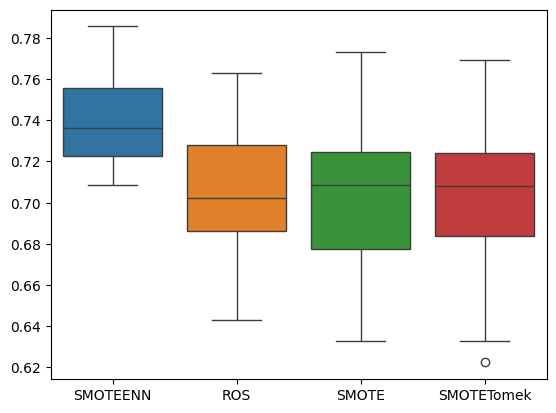

In [22]:
# plot
plot_kfold_results(kfold_results)

# 5. Finalize Model

In [45]:
# search runs
## notes: if using nodes, the function for the node should be present in memory 
run_id = mlflow.search_runs(
    filter_string="tag.pre_pro = 'si(mean)_std_ohe_smoteenn' and tags.base_model = 'XGB'"
)['run_id'].values[0]
model = mlflow.pyfunc.load_model(f"runs:/{run_id}/model")

In [ ]:
model.predict(materials['X_test'])

FBeta score: 0.7534443168771527 
Classification report: 
              precision    recall  f1-score   support

           0       0.96      0.54      0.69      1552
           1       0.42      0.94      0.58       561

    accuracy                           0.64      2113
   macro avg       0.69      0.74      0.64      2113
weighted avg       0.82      0.64      0.66      2113



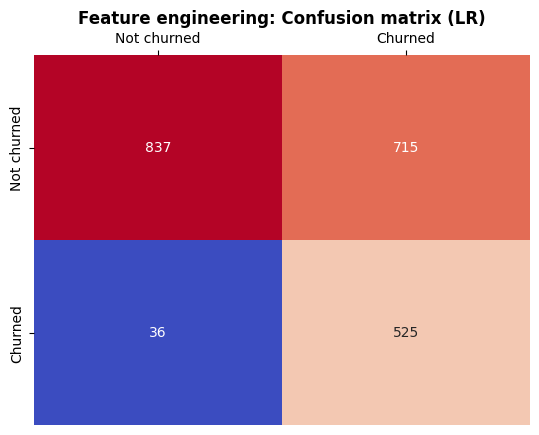

In [29]:
# make predictions 
## fbeta & classification report
val_predictions = model.predict(materials['X_test'])
val_fbeta = fbeta_score(materials['y_test'], val_predictions, 
                        beta=2)
print(f"FBeta score: {val_fbeta} \nClassification report: \n{classification_report(materials['y_test'], val_predictions)}")

## confusion matrix
data = confusion_matrix(materials['y_test'], val_predictions)
g = sns.heatmap(data, 
            annot=True, fmt='.0f', 
            cmap='coolwarm', cbar=False)
g.xaxis.tick_top()
g.set_xticklabels(['Not churned', 'Churned'])
g.set_yticklabels(['Not churned', 'Churned'])
g.set_title(label='Feature engineering: Confusion matrix (LR)', 
            fontdict=dict(weight='bold'))
g.get_figure().savefig('../cache/graphs/fe_conf_matrix_lr.png')

plt.show()